# Coding Assignment : Relax and hold steady 

<p style="text-align:right";>
**Arnaud RUEFF - Antonin URRUTY**
</p>

<p style="text-align:right";>
*À rendre pour le 2 Mai 2016*
</p>


## What do we need to solve ?

Our mission is to solve the stokes flow in a square cavity using the vorticity streamfunction formulation. Stokes flow refers to flow that are dominated by viscous force and not by advective/convective force. In order solve a stokes flow problem, the fluid needs to have a very small Reynolds number (very slow and viscous flow). 

Gladly, the stokes flow assumption will simplify the resolution of the Navier-Stokes equation, as it eliminates the non-linearity of it ! Thus , if we start with the Navier-Stokes equation for incompressible flows : 
$$\frac{\partial u}{\partial t}+u.\nabla u = -\frac{1}{\rho}\nabla p + \nu \nabla^2 u $$


We can show (as shown in the presentation of this assignement) that we need to solve these two coupled equations :

\begin{equation}  
\nabla^2 \omega = 0
\end{equation}

\begin{equation}
\nabla^2 \psi = -\omega
\end{equation}

We recognise here the first equation as a Laplace equation, and the second one as a Poisson equation.





* ### How can we solve these coupled equations ? 

We will use the quite simple and efficient 2D Jacobi iterations.
In two dimensions, the equations look like this :

\begin{equation}
\frac{\partial ^2 \omega}{\partial x^2} + \frac{\partial ^2 \omega}{\partial y^2} = 0
\end{equation}

\begin{equation}
\frac{\partial ^2 \psi}{\partial x^2} + \frac{\partial ^2 \psi}{\partial y^2} = -\omega
\end{equation}

Thus, using Jacobi iterations, we learned in the lessons 1 and 2 from this module that the solutions of theses equations are : 

\begin{equation}
\omega^{k+1}_{i,j} = \frac{1}{4} \left(\omega^{k}_{i,j-1} + \omega^k_{i,j+1} + \omega^{k}_{i-1,j} + \omega^k_{i+1,j} \right)
\end{equation}

\begin{equation}
\psi_{i,j}^{k+1}=\frac{(\psi_{i+1,j}^{k}+\psi_{i-1,j}^{k})\Delta y^2+(\psi_{i,j+1}^{k}+\psi_{i,j-1}^{k})\Delta x^2-\omega_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
\end{equation}

Which, following the exemples of lessons 2 and 3, looks in Pyhton like :

           w[1:-1,1:-1] = .25 x (wk[1:-1,2:] + wk[1:-1, :-2] + wk[2:, 1:-1] + wk[:-2, 1:-1])  
   for the Laplace equation, and
   
           p[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * (  (pk[1:-1,2:]+pk[1:-1,:-2])*dy**2 +\
                                                     (pk[2:,1:-1] + pk[:-2,1:-1])*dx**2 -\
                                                                    w[1:-1,1:-1]*dx**2*dy**2  )
                         
   for the Poisson equation.
   
   *Note that we used the convention used in the previous assignments, with the y coordinates corresponding to the rows of the array and x coordinates on the columns, in order to result on 2D-array values with a natural ordering.*

* ### Boundary conditions

We have for the top boundary ( x, y = max ) :

\begin{equation}
\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j-1} - \psi_{i, j-2}) - \frac{3u_j}{\Delta y} + \mathcal{O}(\Delta y^2)
\end{equation}

Note that in our case ***u = 1***, moreover we will neglect the $\mathcal{O}(\Delta y^2)$ part.

Using the same reasoning than in the notebook explaining how to get the initial condition, we can get the three others.
Let's make an example for the bottom boundary condition (x,y=0). By doing a 2nd order discretisation of the poisson equation

$$\omega_j=\left(\frac{\psi_{j+1}-2\psi_j + \psi_{j-1}}{\Delta y^2}\right) $$ 

we see that this time it's the term $\psi_{j-1}$ that's not in the domain. Thus, by using a 3rd order discretization (but this time a forward difference scheme) of $\frac{\partial \psi}{\partial y}$ on the bottom edge it gives :

$$\frac{\partial \psi}{\partial y}=\frac{-\psi_{j+2}+6\psi_{j+1}-3\psi_j-2\psi_{j-1}}{6\Delta y}=u_j$$


Using the fact that at the bottom boundary, $u_j=\psi_j=0$, isolating $\psi_{j-1}$ and inserting it's expression in the 2nd order discretization of $\omega_j$,

we get for the bottom boundary ( x , y = 0 ) :

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j+1} - \psi_{i, j+2})
\end{equation}

As for the right boundary ( x = max , y ) :

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i-1, j} - \psi_{i-2, j})
\end{equation}

and the the left one ( x = 0 , y ) :

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i+1, j} - \psi_{i+2, j})
\end{equation}

In Python syntax, it looks like :

            w[-1, :] = (-1/(2*dy**2))*(8*p[-2, :] - p[-3, :]) - 3/dy        # We set u=1 and neglected O(dy^2)
            w[0, :]  = (-1/(2*dy**2))*(8*p[1, :] - p[2, :])                 # Bottom boundary condition
            w[:, 0]  = (-1/(2*dx**2))*(8*p[:, 1] - p[:, 2])                 # Right boundary condition
            w[:, -1] = (-1/(2*dx**2))*(8*p[:, -2] - p[:, -3])               # Left boundary condition
        

Where we used the convention   $p_{i,j}$ = p [ j , i ]  again. It will be of course used in the whole assignment.

## The assignment

* #### Importing libraries

We will use Numba as shown in the third lesson of Module 5. 
It is not absolutely necessary but we want to give it a try.

In [1]:
import numpy
import numba
from numba import jit
from matplotlib import pyplot, cm
%matplotlib inline

* **Initial conditions**

The following parameters were given in the presentation of the assignment.

In [2]:
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-6

As well as this function which will help us to compute the L1 norm between successive iterations :

In [3]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

Now we need to set the initial arrays in which our values for $\psi_{i,j}^{k}$ and $\omega_{i,j}^{k}$ will be placed, respecting conventions :

In [4]:
psi_solve = numpy.zeros((ny, nx))   
w_solve = numpy.zeros((ny, nx))

We used *numpy.zeros* to set all the values of the arrays to zero.

* **A function to solve the coupled equations**

We've already seen how the equations look like in Python syntax, so what we need now is to loop them together into a function that will be used to solve our problem.

Note that we used the "if i > 5000" statement to be able to see if our L1norm function would converger or not. 

After having found the right results and the number of iterations used during the impletation, we changed it to 5000 and kept it here just in case.

In [5]:
@jit
def coupled_equations_solver(psi_solve, w_solve, dx, dy, L1norm, l1target, i):
    
    # We set the norms initially to 1, as seen in the notebooks
    L1normpsi = 1
    L1normw = 1
    
    i=0  # We will use this to count the iterations
    
    p = psi_solve.copy()
    w = w_solve.copy()


    while ((l1_target < L1normw) or (l1_target < L1normpsi)) :
        
    
        if i > 5000 :   
            
            break                    
            print('Too many iterations, something wrong with the code !')  
            
        else :
        
            # First of all, setting the newly obtained arrays after the first iteration
        
            wk = w.copy()
            pk = p.copy()
        
        
            # Boundary conditions
        
        
            w[-1, :] = (-1/(2*dy**2))*(8*p[-2, :] - p[-3, :]) - 3/dy        # We set u=1 and neglected O(dy^2)
        
            w[0, :]  = (-1/(2*dy**2))*(8*p[1, :] - p[2, :])                 # Bottom boundary condition
        
            w[:, 0]  = (-1/(2*dx**2))*(8*p[:, 1] - p[:, 2])                 # Right boundary condition
        
            w[:, -1] = (-1/(2*dx**2))*(8*p[:, -2] - p[:, -3])               # Left boundary condition


        
            # Laplace equation
        
            w[1:-1,1:-1] = .25 * (wk[1:-1,2:] + wk[1:-1, :-2] + wk[2:, 1:-1] + wk[:-2, 1:-1])  

        
        
            # Poisson equation
       
            p[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * (   (pk[1:-1,2:]+pk[1:-1,:-2])*dy**2 + \
                                                         (pk[2:,1:-1] + pk[:-2,1:-1])*dx**2 + \
                                                                        w[1:-1,1:-1]*dx**2*dy**2   )
        
            # Now, we need to save the value of the L1 norm so the loop can stop at a moment
        
            L1normw = L1norm(w, wk)      # w = new  and wk = old
            L1normpsi = L1norm(p, pk)    # p = new  and pk = old
        
            i = i + 1
        
    
    
    return p, w, i

* **Now let's solve the problem**

In [6]:
i=0

psi_solve, w_solve, i = coupled_equations_solver(psi_solve, w_solve, dx, dy, L1norm, l1_target, i)

# Showing how many iterations have been necessary

print('\n Number of iterations : ', i ,'\n')   

# Just to check how it looks, we print the resulting arrays

print('\n \n ------------ Values of psi_solve -----------------\n \n ', psi_solve )

print('\n \n ------------ Values of w_solve -----------------\n \n ', w_solve,  '\n \n')



 Number of iterations :  4060 


 
 ------------ Values of psi_solve -----------------
 
  [[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.41429633e-06   2.17360371e-06 ...,   2.17360371e-06
    1.41429633e-06   0.00000000e+00]
 [  0.00000000e+00   2.20482439e-06   1.45898816e-07 ...,   1.45898816e-07
    2.20482439e-06   0.00000000e+00]
 ..., 
 [  0.00000000e+00  -6.35061518e-03  -1.52288240e-02 ...,  -1.52288240e-02
   -6.35061518e-03   0.00000000e+00]
 [  0.00000000e+00  -7.32622358e-03  -1.33638594e-02 ...,  -1.33638594e-02
   -7.32622358e-03   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]

 
 ------------ Values of w_solve -----------------
 
  [[ -0.00000000e+00  -7.28763699e-03  -1.37943448e-02 ...,  -1.37943448e-02
   -7.28763699e-03  -0.00000000e+00]
 [ -7.31261353e-03   2.04601149e-03   1.14128837e-02 ...,  

 * **How long did it take ?**

In [12]:
%%timeit
coupled_equations_solver(psi_solve, w_solve, dx, dy, L1norm, l1_target,i)

10000 loops, best of 3: 187 µs per loop


We wanted to see what Numba was capable of, so we tried a few times to restart the kernel and run it without using Numba (wihtout '@jit' at the beginning of 'coupled_equations_solver').

So using a 2,2 GHz Intel Core i7 Macbook Pro with 8Gb ram, we got 188µs per loop with Numba, and 156µs per loop without Numba. 

Well, either we failed miserably at using numba, or it must be the black magic lessons 3 talked about.

* **What does it look like with pyplot ?**

At last, we will be able to see our results with the viridis colormap !

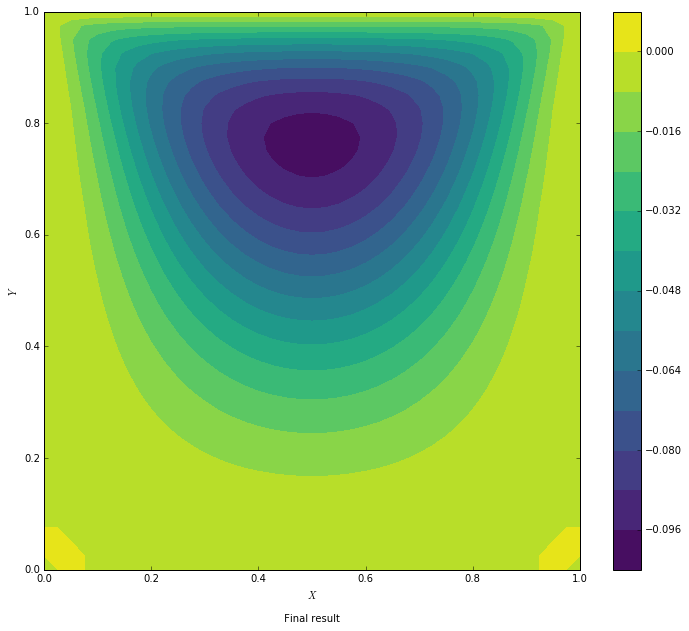

In [8]:
# Plotting axes

x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

# Drawing the plot
pyplot.figure(figsize=(12,10))
pyplot.contourf(x,y,psi_solve,15,cmap=cm.viridis)
pyplot.xlabel('$X$ \n\n Final result ')
pyplot.ylabel('$Y$')
pyplot.colorbar();


It does indeed look as expected.

## Answering the questions asked




* **Maximum value of $ |\psi |$ after relaxation to the specified criteria**

In [9]:
print('\n max of |psi_solve| = ', numpy.amax(numpy.abs(psi_solve)) , '\n')


 max of |psi_solve| =  0.0998451724383 



*  **Maximum value of $|\omega |$ after relaxation to the specified criteria**

In [10]:
print(' \n  max of |w_solve| = ', numpy.amax(numpy.abs(w_solve)) , ' \n')

 
  max of |w_solve| =  78.1926612286  



* **Running**   *** numpy.round( psi[ 32 , ::8 ] , 4 )*** 

In [11]:
print(' \n Result : ',numpy.round(psi_solve[32,::8], 4))

 
 Result :  [ 0.     -0.0575 -0.0944 -0.0944 -0.0575  0.    ]


The values shown below are correct according to the graded assesment page, looks like we got it right !
    
    
        

# Conclusion

The Jacobi method seems to work well to solve the Stokes flow ! 

Though, if the same Stokes flows were to be resolved in a more complicated geometric space, or if the problem to solve was harder, maybe other iterative methods such as Gauss-seidel or successive-over relaxation would have been be more efficient. In these cases, comparing the results with and without using Numba would have been a very intersting challenge. 